In [1]:
%load_ext autoreload
%autoreload 2
%load_ext lab_black

import numpy as np
import pandas as pd
import pickle
import os
import admix_prs
from functools import reduce
from typing import List
import matplotlib.pyplot as plt
import statsmodels.api as sm
from IPython.display import display, Markdown, Latex

# Load data

In [2]:
# PHENO_PATH = "/u/project/pasaniuc/kangchen/tmp/prs-1219/REAL-PHENO/all-pheno.csv"
PHENO_PATH = "all-pheno.csv"
df_pheno = pd.read_csv(PHENO_PATH, index_col=0)

# make ID in the form of FID_IID
df_pheno.index = df_pheno.index.astype(str) + "_" + df_pheno.index.astype(str)

In [3]:
config = "hsq-0.25-pcausal-0.01-hermodel-uniform"

if os.path.exists("df_res_list.pkl"):
    with open("df_res_list.pkl", "rb") as f:
        df_res_list = pickle.load(f)
else:
    df_res_list = admix_prs.load_sim_data(config)
    with open("df_res_list.pkl", "wb") as f:
        pickle.dump(df_res_list, f)

In [4]:
n_sim = len(df_res_list)

In [5]:
# compile all the information per simulation into single data frame
# (or per trait in the real data analsyis)

dict_df_info = dict()
for i_sim in range(n_sim):
    df_prs = df_res_list[i_sim].copy()
    dict_df_info[i_sim] = pd.merge(df_pheno, df_prs, left_index=True, right_index=True)

In [6]:
df_info = dict_df_info[3]
df_info = df_info[df_info["PC1"] > 10].copy()

# make levels
for col in ["PC1", "PC2", "AGE"]:
    df_info[f"{col}_Q"] = pd.qcut(df_info[col], q=5)

# Separate individuals for calibration and testing

In [7]:
np.random.seed(1234)
calibrate_idx = np.random.choice(
    df_info.index, size=int(len(df_info) * 0.1), replace=False
).tolist()
test_idx = list(set(df_info.index) - set(calibrate_idx))

print(f"Number of individuals, calibrate: {len(calibrate_idx)}; test: {len(test_idx)}")

Number of individuals, calibrate: 1955; test: 17597


# Test whether a specific covariate influence the predictivity of PRS.

In [8]:
het_stats, het_model = admix_prs.test_het_breuschpagan(
    df=df_info.dropna(), y_col="PHENO", pred_col="PRS_MEAN", test_col="PC1"
)
display(het_stats)

# we see a positive variance associated with PC1
print(het_model.summary())

Lagrange multiplier statistic    3.789516
p-value                          0.051575
f-value                          3.789931
f p-value                        0.051579
dtype: float64

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     3.790
Date:                Thu, 17 Feb 2022   Prob (F-statistic):             0.0516
Time:                        13:24:50   Log-Likelihood:                -26628.
No. Observations:               16352   AIC:                         5.326e+04
Df Residuals:                   16350   BIC:                         5.328e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.8451      0.014     59.540      0.0

# Evaluate the model prediction using various metrics, perform conformal inference

## Raw results

In [9]:
for col in ["PC1_Q", "PC2_Q", "SEX", "AGE_Q"]:
    display(Markdown(f"### {col}"))

    display(
        admix_prs.evaluate(
            df_info,
            y_col="PHENO_G",
            pred_col="PRS_MEAN",
            predstd_col="PRS_STD",
            group_col=col,
        )
    )

### PC1_Q

,r2,coverage,length
PC1_Q,,,
"(9.999, 28.463]",0.719925,0.671951,0.447875
"(28.463, 65.141]",0.698990,0.601023,0.464507
"(65.141, 154.6]",0.698881,0.604449,0.483750
"(154.6, 382.575]",0.626972,0.898184,0.611628
"(382.575, 419.396]",0.529863,0.935822,0.679086


### PC2_Q

,r2,coverage,length
PC2_Q,,,
"(-282.318, -104.879]",0.681345,0.720020,0.511600
"(-104.879, -83.425]",0.695988,0.564962,0.470887
"(-83.425, -9.615]",0.715530,0.680563,0.452233
"(-9.615, 72.566]",0.580494,0.809974,0.573640
"(72.566, 86.112]",0.533456,0.935822,0.678438


### SEX

,r2,coverage,length
SEX,,,
0,0.619412,0.756404,0.544302
1,0.629612,0.726404,0.529571


### AGE_Q

,r2,coverage,length
AGE_Q,,,
"(39.999, 45.0]",0.606776,0.757327,0.550702
"(45.0, 50.0]",0.614557,0.756211,0.550162
"(50.0, 56.0]",0.618867,0.745263,0.540687
"(56.0, 62.0]",0.639080,0.717012,0.518515
"(62.0, 72.0]",0.648378,0.731322,0.522600


## Perform calibration

In [10]:
np.random.seed(1)

# perform calibration
df_calibrated = admix_prs.calibrate_pred(
    df_info,
    y_col="PHENO",
    pred_col="PRS_MEAN",
    predstd_col="PRS_STD",
    calibrate_idx=calibrate_idx,
    ci_method="shift",
    mean_adjust_cols=["SEX"],
    ci_adjust_cols=["PC1"],
    ci=0.9,
)
covar_cols = ["PHENO", "PC1", "PC1_Q", "PC2_Q", "SEX", "AGE_Q"]
df_calibrated[covar_cols] = df_info[covar_cols].reindex(df_calibrated.index)

for col in ["PC1_Q"]:
    display(Markdown(f"### {col}"))

    display(
        admix_prs.evaluate(
            df_calibrated.loc[
                test_idx,
            ],
            y_col="PHENO",
            pred_col="PRS_MEAN",
            predstd_col="PRS_STD",
            group_col=col,
            ci=0.9,
        )
    )

2022-02-17 13:24.51 [info     ] Regress pred_col=PRS_MEAN against mean_adjust_cols=['SEX'] fitted with `calibrate_index` individuals
2022-02-17 13:24.51 [info     ] mean_model.summary():                             OLS Regression Results                            
Dep. Variable:                  PHENO   R-squared:                       0.163
Model:                            OLS   Adj. R-squared:                  0.162
Method:                 Least Squares   F-statistic:                     190.5
Date:                Thu, 17 Feb 2022   Prob (F-statistic):           2.66e-76
Time:                        13:24:51   Log-Likelihood:                -2627.8
No. Observations:                1955   AIC:                             5262.
Df Residuals:                    1952   BIC:                             5278.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef  

### PC1_Q

,r2,coverage,length
PC1_Q,,,
"(9.999, 28.463]",0.192850,0.899295,1.504178
"(28.463, 65.141]",0.159406,0.894449,1.509666
"(65.141, 154.6]",0.177502,0.901705,1.519375
"(154.6, 382.575]",0.131450,0.905209,1.580656
"(382.575, 419.396]",0.125233,0.908526,1.607949


# Visualization of results

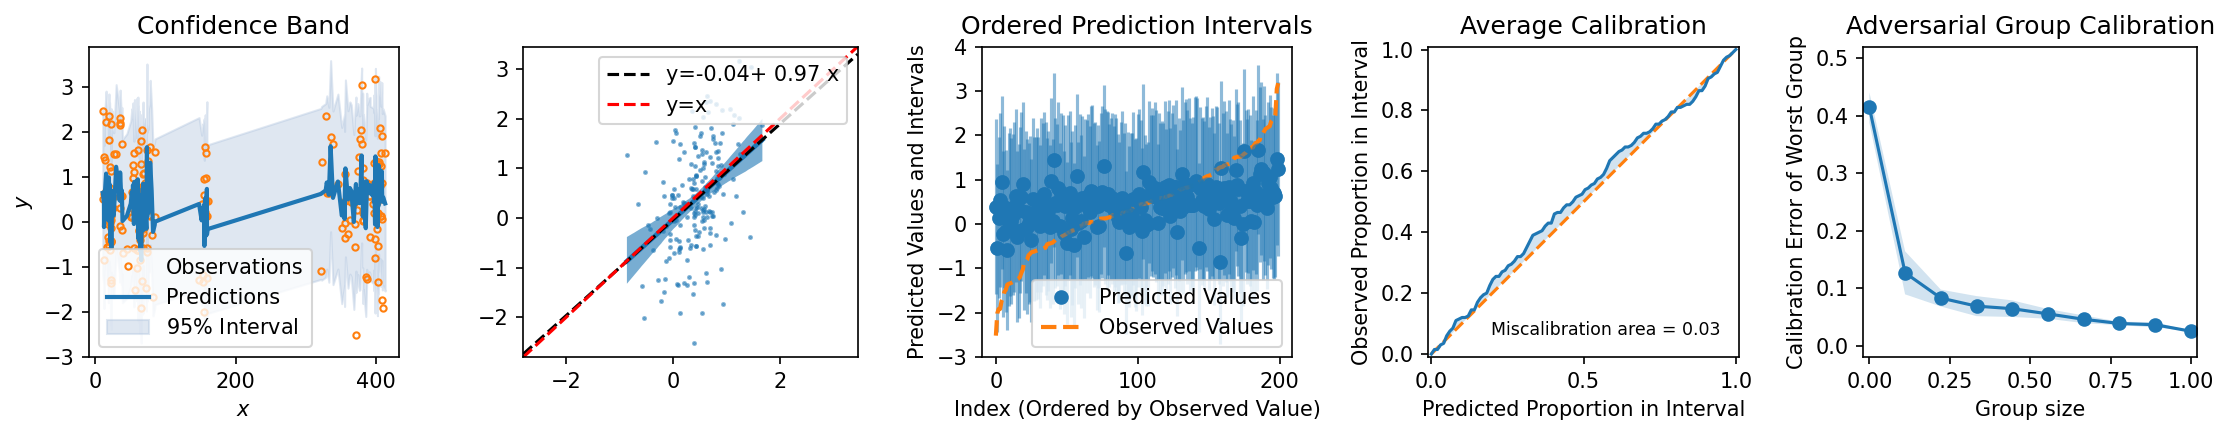

In [11]:
df_tmp = df_calibrated.sample(n=200, random_state=42)
admix_prs.uct_plot(
    pred_mean=df_tmp["PRS_MEAN"].values,
    pred_std=df_tmp["PRS_STD"].values,
    y=df_tmp["PHENO"].values,
    x=df_tmp["PC1"].values,
)

In [12]:
admix_prs.uct_metrics(
    pred_mean=df_tmp["PRS_MEAN"].values,
    pred_std=df_tmp["PRS_STD"].values,
    y=df_tmp["PHENO"].values,
    #     x=df_tmp["PC1"].values,
)

 (1/n) Calculating accuracy metrics
 (2/n) Calculating average calibration metrics
 (3/n) Calculating adversarial group calibration metrics
  [1/2] for mean absolute calibration error
Measuring adversarial group calibration by spanning group size between 0.0 and 1.0, in 10 intervals


100%|██████████| 10/10 [00:00<00:00, 11.45it/s]


  [2/2] for root mean squared calibration error
Measuring adversarial group calibration by spanning group size between 0.0 and 1.0, in 10 intervals


100%|██████████| 10/10 [00:00<00:00, 11.04it/s]

 (4/n) Calculating sharpness metrics
 (n/n) Calculating proper scoring rule metrics
**Finished Calculating All Metrics**


===================== Accuracy Metrics =====================
  MAE           0.724
  RMSE          0.930
  MDAE          0.566
  MARPD         116.787
  R2            0.164
  Correlation   0.408
=============== Average Calibration Metrics ================
  Root-mean-squared Calibration Error   0.029
  Mean-absolute Calibration Error       0.025
  Miscalibration Area                   0.025
========== Adversarial Group Calibration Metrics ===========
  Mean-absolute Adversarial Group Calibration Error
     Group Size: 0.11 -- Calibration Error: 0.119
     Group Size: 0.56 -- Calibration Error: 0.050
     Group Size: 1.00 -- Calibration Error: 0.025
  Root-mean-squared Adversarial Group Calibration Error
     Group Size: 0.11 -- Calibration Error: 0.135
     Group Size: 0.56 -- Calibration Error: 0.058
     Group Size: 1.00 -- Calibration Error: 0.029
==============

{'accuracy': {'mae': 0.7239494584702849,
  'rmse': 0.9298867394383354,
  'mdae': 0.5656806792312852,
  'marpd': 116.78659813282772,
  'r2': 0.16376141280380452,
  'corr': 0.40809279542245575},
 'avg_calibration': {'rms_cal': 0.029486885745640044,
  'ma_cal': 0.024952525252525243,
  'miscal_area': 0.02507079891477187},
 'adv_group_calibration': {'ma_adv_group_cal': {'group_sizes': array([0.        , 0.11111111, 0.22222222, 0.33333333, 0.44444444,
          0.55555556, 0.66666667, 0.77777778, 0.88888889, 1.        ]),
   'adv_group_cali_mean': array([0.33643939, 0.1190303 , 0.08864899, 0.06707237, 0.0602035 ,
          0.04967322, 0.04830417, 0.03898291, 0.03489053, 0.02495253]),
   'adv_group_cali_stderr': array([7.28781725e-02, 1.83168356e-02, 2.08603972e-02, 1.18266388e-02,
          7.06951286e-03, 9.97704647e-03, 9.22795342e-03, 5.27209566e-03,
          3.43370015e-03, 3.65711820e-18])},
  'rms_adv_group_cal': {'group_sizes': array([0.        , 0.11111111, 0.22222222, 0.33333333, 0